## Sigma clipping
Reference: https://www.gnu.org/software/gnuastro/manual/html_node/Sigma-clipping.html
1. Realize sigma clipping 
2. Test on the images
3. Compare the criteria of selecting mean and median

In [1]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import gridspec

In [2]:
import numpy as np
from astropy.io import fits

In [3]:
# Define the sigma clipping function
def sigma_clip(image, alpha=0.5, iters=50, ratio=1.0, normflag=False, avgmode=False):
    """Sigma clipping"""
    if normflag:
        # normalization
        image = (image - image.min()) / (image.max() - image.min())
    # clipping
    image_clip = image.copy()
    sigma_old = 10000.0
    for i in range(iters):
        sigma = np.nanstd(image_clip)
        if avgmode:
            median = np.nanmean(image_clip)
        else:
            median = np.nanmedian(image_clip)
        # clipping
        lwbound = median - alpha * sigma
        upbound = median + alpha * sigma
        image_clip[image_clip < lwbound] = np.nan
        image_clip[image_clip > upbound] = np.nan
        # update and stop
        if (sigma_old - sigma) / sigma < ratio: 
            break
        
        sigma_old = sigma
    
    # Fill nan with 0
    image_clip[np.isnan(image_clip)] = 0.0
    image_eh = image - image_clip
    
    return image_clip, image_eh

### load image

In [4]:
with fits.open("./hcg62.fits") as h:
    img = h[0].data
img = np.flipud(img)
img = img[375-100+1:375+100+1,375-100+1:375+100+1]
# img = np.log(img[400-50+1:400+50+1,400-50+1:400+50+1]+1e-5)
# smooth
from scipy.ndimage.filters import gaussian_filter
img = gaussian_filter(img, sigma=2)

### Test and Compare

In [5]:
gs = gridspec.GridSpec(2, 6, wspace=0.1, hspace=0.1)

In [6]:
alphas = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0]
iters = 10
ratio = 1.0
normflag = False

(-0.5, 199.5, 199.5, -0.5)

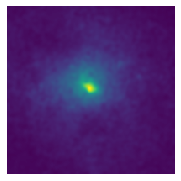

In [7]:
plt.rcParams["figure.figsize"] = [3.0, 5.0]
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.axis('off')

/home/mzx/.local/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in greater
/home/mzx/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in less


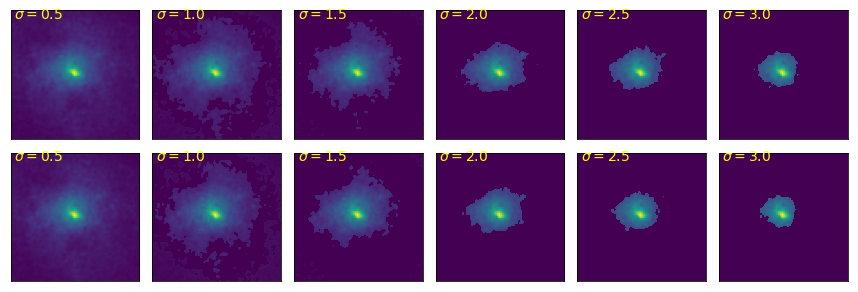

In [8]:
plt.rcParams["figure.figsize"] = [15.0, 5.0]
for i, alpha in enumerate(alphas):
    # median
    img_clip_m, img_eh_m = sigma_clip(
        img, alpha=alpha, iters=iters, ratio=ratio, normflag=normflag, avgmode=False) 
    # avg
    img_clip_a, img_eh_a = sigma_clip(
        img, alpha=alpha, iters=iters, ratio=ratio, normflag=normflag, avgmode=True) 
    # draw image
    ax1 = plt.subplot(gs[0,i])
    ax1.imshow(img_eh_m)
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.set_axis_off
    plt.text(5, 12, '$\sigma = %.1f$' % (alpha), color='yellow', fontsize=14)
    ax2 = plt.subplot(gs[1,i])
    ax2.imshow(img_eh_a)
    plt.text(5, 12, '$\sigma = %.1f$' % (alpha), color='yellow', fontsize=14)
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax2.set_axis_off
plt.savefig("fig_sigmaclip_hcg62.png", bbox_inches='tight', dpi=200)